<h1>Customer Churn Prediction Using Artificial Neural Networks (ANN)</h1>

This project uses the **Churn Modelling** dataset to predict whether a bank customer will exit (churn) based on demographic, account, and activity details.
  
- Pre-process the dataset (encode categorical data, scale features)
- Build and train an Artificial Neural Network
- Evaluate performance using confusion matrix, precision, recall, F1-score, and ROC curve
- Deploy for single-customer prediction

## Step 1: Import Libraries and Load Dataset

In [88]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle

In [89]:
#Import Dataset
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Step 2: Data Preprocessing
We will do an initial visualisation of features <br>
We remove irrelevant columns, encode categorical variables, and scale numerical features.


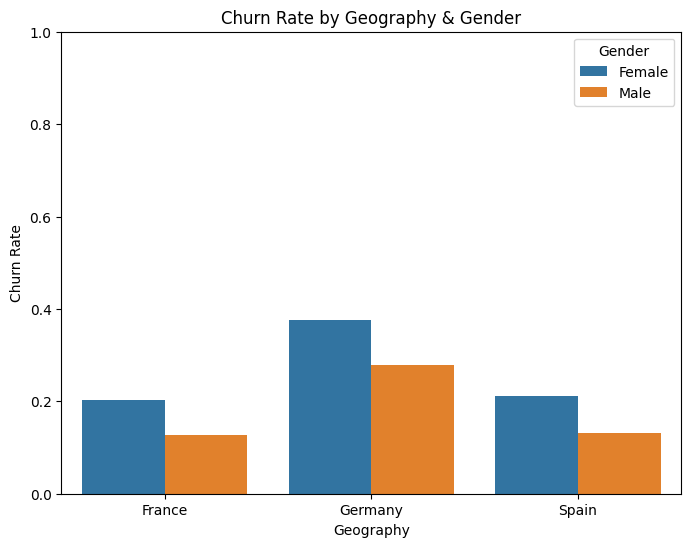

In [90]:
geo_gender_churn = data.groupby(['Geography', 'Gender'])['Exited'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=geo_gender_churn, x='Geography', y='Exited', hue='Gender')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Geography & Gender')
plt.ylim(0,1)
plt.show()

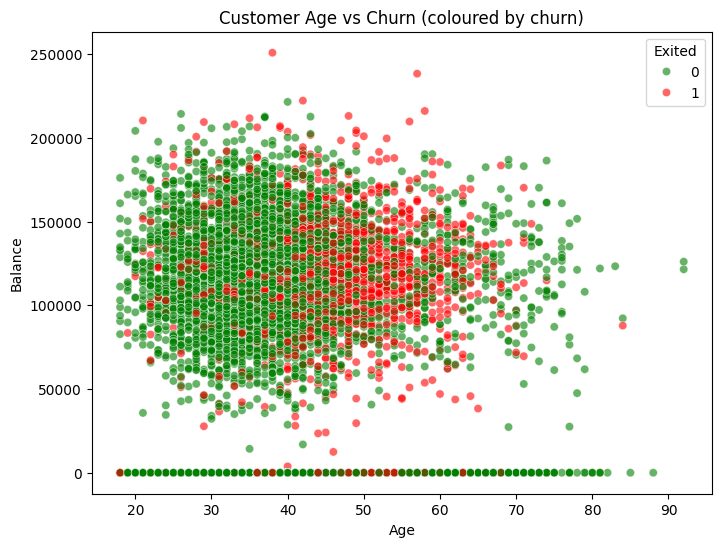

In [91]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x='Age', y='Balance', hue='Exited', palette={0: 'green', 1: 'red'}, alpha=0.6)
plt.title('Customer Age vs Churn (coloured by churn)')
plt.ylabel('Balance')
plt.show()

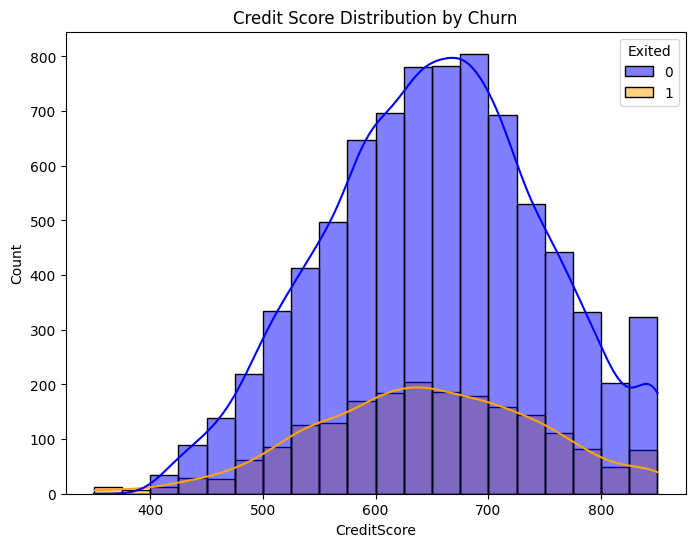

In [92]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='CreditScore', hue='Exited', bins=20, kde=True, palette={0: 'blue', 1: 'orange'}, alpha=0.5)
plt.title('Credit Score Distribution by Churn')
plt.show()

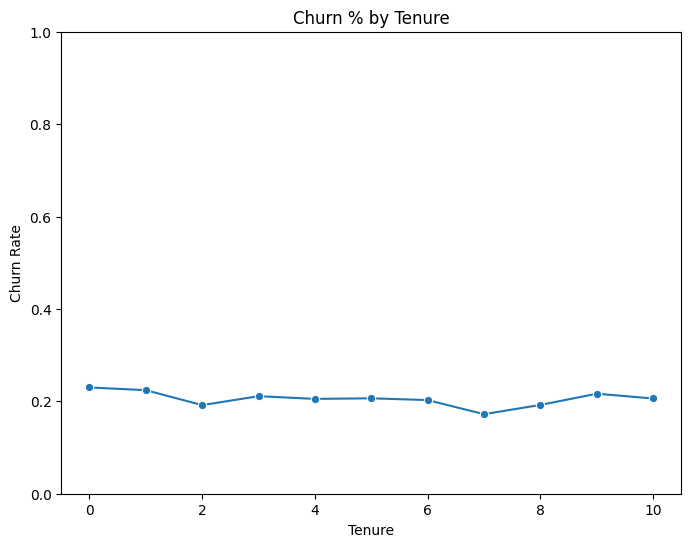

In [93]:
tenure_churn = data.groupby('Tenure')['Exited'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=tenure_churn, x='Tenure', y='Exited', marker='o')
plt.ylabel('Churn Rate')
plt.title('Churn % by Tenure')
plt.ylim(0,1)
plt.show()

In [94]:
#Drop RowNumber, CustomerId, and Surname since they are identifiers and don’t help in prediction
data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [95]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [96]:
list(data['Gender'].unique())

['Female', 'Male']

In [97]:
#Encode Gender using LabelEncoder
label_encoder_gender = LabelEncoder()
data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [98]:
#One-hot encode Geography
encoder = OneHotEncoder(sparse_output=False)
geo_encoded = encoder.fit_transform(data[['Geography']])
geo_df = pd.DataFrame(geo_encoded, columns=encoder.get_feature_names_out(['Geography']))
data = pd.concat([data.drop('Geography', axis=1), geo_df], axis=1)

In [99]:
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0


In [100]:
#Save encoders for later use
with open('label_encoder_gender.pkl', 'wb') as file:
    pickle.dump(label_encoder_gender, file) 

with open('one_hot_encoder_geo.pkl', 'wb') as file:
    pickle.dump(encoder, file) 

## Step 3: Split Data and Scale Features
We split the dataset into training and testing sets and standardize numerical features using `StandardScaler`.

In [101]:
y = data['Exited']
X = data.drop(columns=['Exited'], axis = 1)

In [102]:
#Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [103]:
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
#Save encoders
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file) 

## Step 4: Build the ANN Model
The ANN has:
- Input layer matching the number of features
- Two hidden layers with ReLU activation and dropout for regularization
- Output layer with sigmoid activation for binary classification

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.regularizers import l2
from tensorflow.keras.models import load_model
import datetime

In [106]:
(X_train.shape[1],)

(12,)

In [107]:
#BUILD ANN MODEL

model = Sequential([
    Input((X_train.shape[1],)),
    Dense(64, activation='relu',kernel_regularizer=l2(0.001)), #Hidden Layer 1 - Connected with input layer
    Dropout(0.3),
    Dense(32, activation = 'relu'), #Hidden Layer 2
    Dropout(0.3),
    Dense(1, activation = 'sigmoid') # Output Layer
])

In [108]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Compile and Train the Model
Used:
- Adam optimizer (learning rate 0.0001)
- Binary crossentropy loss
- Early stopping to prevent overfitting
- TensorBoard for visualization

In [109]:
#Initialise the optimiser for backprop and loss
opt = Adam(learning_rate = 0.0001)
loss = BinaryCrossentropy()

In [110]:
## Compile Model
model.compile(optimizer = opt, loss = loss, metrics=['accuracy'])

In [111]:
#Set up TensorBoard - visualise logs when training model
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorflow_callback = TensorBoard(log_dir = log_dir, histogram_freq=1)

In [112]:
#Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [113]:
#Training the Model
history = model.fit(
    X_train, y_train, validation_data = (X_test, y_test), epochs = 100,
    callbacks = [tensorflow_callback, early_stopping]
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5624 - loss: 0.7017 - val_accuracy: 0.7960 - val_loss: 0.5742
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7676 - loss: 0.5550 - val_accuracy: 0.8080 - val_loss: 0.4975
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.7891 - loss: 0.5189 - val_accuracy: 0.8080 - val_loss: 0.4723
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7933 - loss: 0.4994 - val_accuracy: 0.8080 - val_loss: 0.4602
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.4907 - val_accuracy: 0.8080 - val_loss: 0.4510
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.7958 - loss: 0.4845 - val_accuracy: 0.8090 - val_loss: 0.4447
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7950 - loss: 0.4793 - val_accuracy: 0.8105 - val_loss: 0.4398
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7980 - loss: 0.478

In [114]:
model.save('model.h5')

In [141]:
#Load Tensorboard extension
%reload_ext tensorboard

In [142]:
%tensorboard --logdir logs/fit20250810-184024

Reusing TensorBoard on port 6012 (pid 99159), started 0:01:30 ago. (Use '!kill 99159' to kill it.)

## Step 6: Evaluate Model
We use:
- Confusion Matrix
- Precision, Recall, and F1-score
- ROC Curve with AUC

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
Confusion Matrix:
 [[1559   57]
 [ 202  182]]


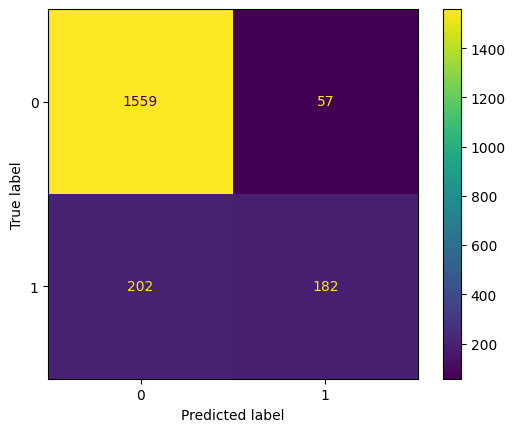

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_probs = model.predict(X_test)

y_pred = (y_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

What it means:<br><br>
TN (1559) -> Safe: predicted stay, actually stayed<br>
FP (57) ->  False alarm: predicted churn, but they stayed<br>
FN (202) ->  Missed churner: predicted stay, but they left<br>
TP (182) ->  Success: predicted churn, they left<br>

<br>
FN is the important metric here, since a missing a churner means you lose a customer without intervention.

In [118]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.7615
Recall: 0.4740
F1-score: 0.5843


Precision: <br>
Meaning: When the model predicts “Churn”, it’s correct ~76% of the time
High precision -> Few false alarms

Recall: <br>
Meaning: Out of all actual churners, the model catches ~47%.
Lower recall -> Many churners are missed (false negatives) - This is low if the business wants to save as many churners as possible.

F1-Score: <br>
Meaning: Harmonic mean of precision and recall
Here, F1 is pulled down by the low recall


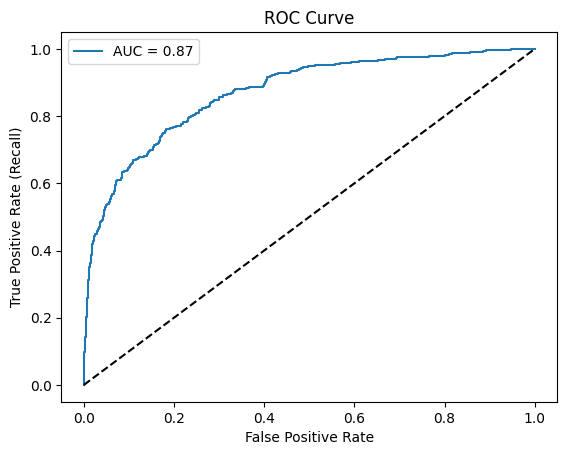

In [119]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

ROC plots True Positive Rate (Recall) vs False Positive Rate at different thresholds.<br>
AUC (Area Under Curve) = probability the model ranks a random churner higher than a random non-churner.

0.87 is strong, the model has good separation between churners and non-churners.

## Step 7: Finding the Best Classification Threshold
We vary thresholds from 0.0 to 1.0 and choose the one that maximizes the F1-score.  
This helps balance precision and recall.

In [120]:
y_probs = model.predict(X_test)
y_probs = y_probs.flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


In [121]:
thresholds = np.arange(0.0, 1.01, 0.01)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")


Best threshold: 0.36 with F1-score: 0.6333


At a 0.36 cutoff, the model gives the best balance between precision and recall for this dataset<br>
This is better than the earlier threshold of 0.34 where F1 was 0.5742<br>
F1 going from 0.58 -> 0.633 means we are catching more churners without losing too much precision.

/Users/kulfi/Desktop/Complete-Python-Bootcamp-main/1-Python Basics/ANN PROJECT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


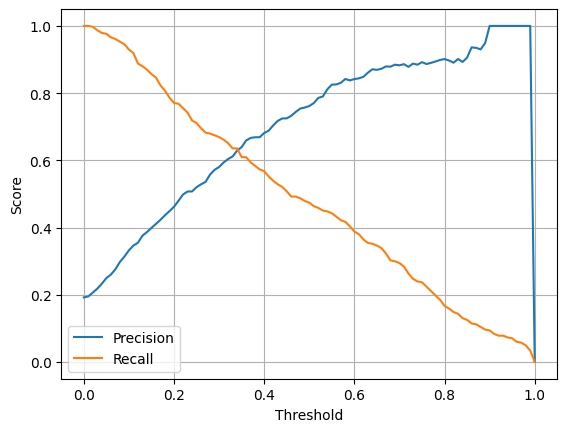

In [122]:
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


## Step 8: Predict for a Single New Customer
We preprocess the input in the same way as the training data and then use the model to predict churn probability.

In [123]:
# Load trained model, scaler pickle, onehot and label encoder
model = load_model('model.h5')

In [124]:
with open('label_encoder_gender.pkl', 'rb') as file:
    label_gender = pickle.load(file)

with open('one_hot_encoder_geo.pkl', 'rb') as file:
    one_hot_geo = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)    

In [125]:
print(one_hot_geo.categories_)
print(one_hot_geo.get_feature_names_out(['Geography']))

[array(['France', 'Germany', 'Spain'], dtype=object)]
['Geography_France' 'Geography_Germany' 'Geography_Spain']


In [126]:
sample_customer = {
    "CreditScore": 720,          # Good credit score
    "Gender": 'Female',          
    "Age": 35,                   # Age in years
    "Tenure": 5,                 # Years with bank
    "Balance": 75000.00,         # Account balance
    "NumOfProducts": 2,          # Products with bank
    "HasCrCard": 1,              # 1 = Has credit card
    "IsActiveMember": 1,         # 1 = Active
    "EstimatedSalary": 85000.00, # Annual salary
    "Geography": 'France'
}

In [127]:
new_data = pd.DataFrame(sample_customer, index = [0])
new_data['Gender'] = label_gender.transform(new_data['Gender'])
new_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography
0,720,0,35,5,75000.0,2,1,1,85000.0,France


In [128]:
geo_encoded = one_hot_geo.transform(new_data[['Geography']])
geo_df = pd.DataFrame(
    geo_encoded,
    columns=one_hot_geo.get_feature_names_out(['Geography']),
    index=new_data.index
)
new_data = pd.concat([new_data.drop(columns=['Geography']), geo_df], axis=1)

In [129]:
new_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,720,0,35,5,75000.0,2,1,1,85000.0,1.0,0.0,0.0


In [130]:
values_array = new_data.to_numpy()
values_array.shape

(1, 12)

In [131]:
values_df = pd.DataFrame(values_array, columns=scaler.feature_names_in_)
scaled_values = scaler.transform(values_df)

In [132]:
prediction = model.predict(scaled_values)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.06702351]], dtype=float32)

In [133]:
prediction_prob = prediction[0][0]

In [134]:
final_threshold = best_threshold
prob = float(prediction_prob)  # Convert array to plain float

# For a single customer
if prediction_prob >= final_threshold:
    confidence = prob * 100
    rint(f"Customer is likely to CHURN (Confidence: {confidence:.2f}%)")
else:
    confidence = (1 - prob) * 100
    print(f"Customer is likely to NOT CHURN (Confidence: {confidence:.2f}%)")

Customer is likely to NOT CHURN (Confidence: 93.30%)
